In [1]:
import sys
sys.path.append("./FinRL-Meta")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from meta.data_processors.akshare import Akshare
from meta.data_processors.baostock import Baostock
from agents.rllib_models_new import DRLAgent
from env.basic import StockTradingEnv_lookback

## Data

In [2]:
time_interval = "d"
start_date="2017-01-01"
end_date='2023-01-01'

ticket_list=['600000.XSHG', '600009.XSHG', '600016.XSHG', '600028.XSHG', '600030.XSHG']

TECHNICAL_INDICATORS_LIST = ['macd','boll_ub','boll_lb','rsi_30','dx_30','close_30_sma',
                             'close_60_sma']

In [3]:
processor = Baostock("baostock",start_date=start_date,end_date=end_date,time_interval=time_interval)
processor.download_data(ticket_list)
processor.clean_data()
processor.fillna()
processor.add_technical_indicator(TECHNICAL_INDICATORS_LIST,drop_na_timesteps = 0)
processor.fillna()
df = processor.dataframe

login success!
baostock login respond error_code:0
baostock login respond  error_msg:success
baostock download_data respond error_code:0
baostock download_data respond  error_msg:success
baostock download_data respond error_code:0
baostock download_data respond  error_msg:success
baostock download_data respond error_code:0
baostock download_data respond  error_msg:success
baostock download_data respond error_code:0
baostock download_data respond  error_msg:success
baostock download_data respond error_code:0
baostock download_data respond  error_msg:success
logout success!
Download complete! Dataset saved to ./data/dataset.csv. 
Shape of DataFrame: (7295, 7)
Shape of DataFrame:  (7295, 8)
tech_indicator_list:  ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'dx_30', 'close_30_sma', 'close_60_sma']
indicator:  macd
indicator:  boll_ub
indicator:  boll_lb
indicator:  rsi_30
indicator:  dx_30
indicator:  close_30_sma
indicator:  close_60_sma
Succesfully add technical indicators
Shape of DataFrame

In [4]:
def plot_tics(df,on = "close"):
    df.time = pd.to_datetime(df.time)
    plt.figure(figsize=(25,4))
    for id,tic in enumerate(df.tic.unique()[:5]):
        ax = plt.subplot(1,5,id+1)
        plt.title(tic)
        df[df.tic == tic].set_index("time")[on].plot()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

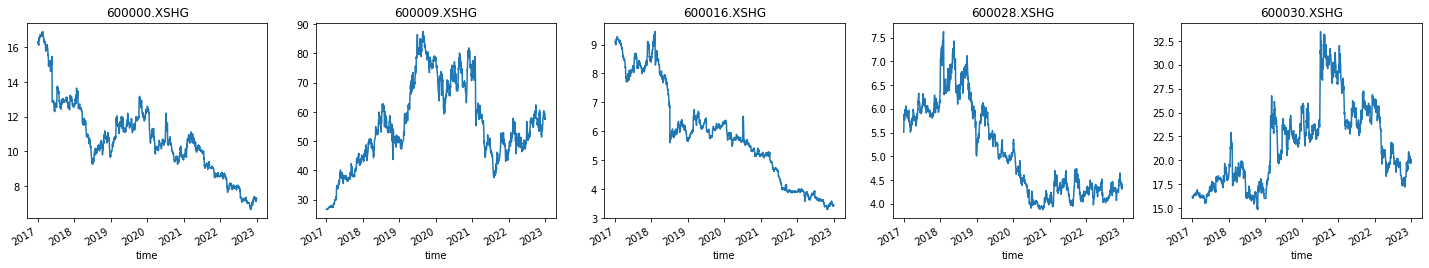

In [5]:
plot_tics(df)

## Run

In [6]:
train = df[df.time < "2021-01-01"]
train.shape

(4870, 16)

In [7]:
train_env_kwargs = {
        # "file_path":train_data_path,
        "df":train,
        "hmax": 1000,
        "buy_cost_pct":6.87e-5,
        "sell_cost_pct":1.0687e-5,
        "reward_scaling": 1e-2,
        
        "lookback_days":31,
        "initial_cash":1e6,
        
        "relative_action":False,
        "full_buy":False,
        # "T+1":True,
        
        "cash_showing":"no",
        'stock_hold_showing':"actual_holding",
        "holding_at_beginning":"same_pct",
        "output_type":"numpy_array",
                
}

In [8]:
agent = DRLAgent(env = StockTradingEnv_lookback)
model, model_config = agent.get_model("ppo",train_env_kwargs)

2023-02-07 16:18:44,575	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8265


In [9]:
# the following is the resources setting on RTX 3070
num_rollout_workers = 6 # number of workers
gpu_count = 1 # number od GPU(s) 
trainer_gpu = 0.2 # pct of GPU taken by the main trainer
num_gpus_per_worker = (gpu_count - trainer_gpu) / num_rollout_workers # pct of GPU taken by the workers

# === setting ===
model_config['num_workers'] = num_rollout_workers
model_config["num_gpus"] = trainer_gpu
model_config["num_gpus_per_worker"] = num_gpus_per_worker
model_config["num_cpus_per_worker"] = 1

In [10]:
trainer = agent.train_model(
    model = model,
    model_name = "ppo",
    model_config = model_config,
    total_episodes = 10)

2023-02-07 16:18:48,787	WARNING ppo.py:395 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=6 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 666.
2023-02-07 16:18:48,788	INFO ppo.py:415 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2023-02-07 16:18:48,788	INFO trainer.py:906 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(RolloutWorker pid=22972) Total timesteps: 944. Starting from 2017-02-21T00:00:00.000000000 to 2020-12-31T00:00:00.000000000
(RolloutWorker pid=13920) Total timesteps: 944. Starting from 2017-02-21T00:00:00.000000000 to 2020-12-31T00:00:00.000000000


(RolloutWorker pid=22972) 2023-02-07 16:18:51,699	WARNING env.py:136 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=13920) 2023-02-07 16:18:51,777	WARNING env.py:136 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=14884) 2023-02-07 16:18:51,907	WARNING env.py:136 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=11912) 2023-02-07 16:18:51,868

(RolloutWorker pid=14884) Total timesteps: 944. Starting from 2017-02-21T00:00:00.000000000 to 2020-12-31T00:00:00.000000000
(RolloutWorker pid=11912) Total timesteps: 944. Starting from 2017-02-21T00:00:00.000000000 to 2020-12-31T00:00:00.000000000
(RolloutWorker pid=11768) Total timesteps: 944. Starting from 2017-02-21T00:00:00.000000000 to 2020-12-31T00:00:00.000000000
(RolloutWorker pid=3240) Total timesteps: 944. Starting from 2017-02-21T00:00:00.000000000 to 2020-12-31T00:00:00.000000000
(RolloutWorker pid=11768) Episode: 2
(RolloutWorker pid=11768) Cumulated Return:  235272.4624873211.Cumulated Return Rate: 0.23527246248732112
(RolloutWorker pid=22972) Episode: 2
(RolloutWorker pid=22972) Cumulated Return:  125029.10585304466.Cumulated Return Rate: 0.12502910585304466
(RolloutWorker pid=13920) Episode: 2
(RolloutWorker pid=13920) Cumulated Return:  532112.7181328535.Cumulated Return Rate: 0.5321127181328534
(RolloutWorker pid=11912) Episode: 2
(RolloutWorker pid=11912) Cumulated

## backtest

In [11]:
test = df[df.time >= "2021-01-01"] 
test.shape

(2425, 16)

In [12]:
test_env_kwargs = {         
        # "file_path":train_data_path,         
        "df":test,         
        "hmax": 1000,         
        "buy_cost_pct":6.87e-5,         
        "sell_cost_pct":1.0687e-5,         
        "reward_scaling": 1e-2,                  
        "lookback_days":31,         
        "initial_cash":1e6,                  
        "relative_action":False,         
        "full_buy":False,         
        # "T+1":True,                  
        "cash_showing":"no",         
        'stock_hold_showing':"actural_holding",         
        "holding_at_beginning":"same_pct",         
        "output_type":"numpy_array",                  
    }

In [13]:
backtester = agent.DRL_prediction(
        "ppo",
        StockTradingEnv_lookback,
        test_env_kwargs,
        agent_path="./test_ppo/checkpoint_000010/checkpoint-10",
    )

2023-02-07 16:23:26,486	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8265
(RolloutWorker pid=1568) 2023-02-07 16:23:32,486	WARNING env.py:136 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=26164) 2023-02-07 16:23:32,531	WARNING env.py:136 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


(RolloutWorker pid=1568) Total timesteps: 455. Starting from 2021-02-22T00:00:00.000000000 to 2022-12-30T00:00:00.000000000
(RolloutWorker pid=26164) Total timesteps: 455. Starting from 2021-02-22T00:00:00.000000000 to 2022-12-30T00:00:00.000000000


2023-02-07 16:23:33,540	INFO trainable.py:589 -- Restored on 127.0.0.1 from checkpoint: ./test_ppo/checkpoint_000010/checkpoint-10
2023-02-07 16:23:33,541	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 265.4470794200897, '_episodes_total': 84}


Restoring from checkpoint path ./test_ppo/checkpoint_000010/checkpoint-10


In [14]:
# test on the testing env
env_instance = StockTradingEnv_lookback(test_env_kwargs)
account_memory = []
actions_memory = []
state = env_instance.reset()
episode_returns = []  # the cumulative_return / initial_account
episode_total_assets = [env_instance.initial_total_asset]
done = False
while not done:
    action = backtester(state)
    state, reward, done, _ = env_instance.step(action)
    if done:
        print("hit end!")
        break

account_memory = env_instance.save_asset_memory()
actions_memory = env_instance.save_action_memory()

Total timesteps: 455. Starting from 2021-02-22T00:00:00.000000000 to 2022-12-30T00:00:00.000000000
Episode: 1
Cumulated Return:  -244735.02153460763.Cumulated Return Rate: -0.2447350215346076
hit end!


<AxesSubplot:>

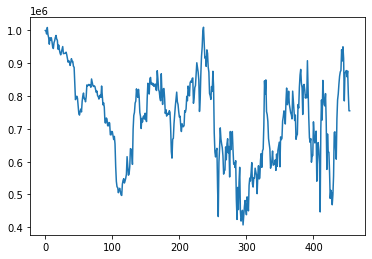

In [15]:
# asset
account_memory.account_value.plot()

In [16]:
actions_memory

,600000.XSHG,600009.XSHG,600016.XSHG,600028.XSHG,600030.XSHG
2021-02-22,18672.0,3283.0,38092.0,43007.0,7201.0
2021-02-23,-1000.0,1000.0,-420.0,165.0,443.0
2021-02-24,-305.0,-250.0,1000.0,-151.0,-836.0
2021-02-25,1342.0,-565.0,-1000.0,3652.0,-562.0
2021-02-26,1389.0,359.0,-1000.0,-1000.0,-1000.0
...,...,...,...,...,...
2022-12-26,0.0,1000.0,588.0,1000.0,-726.0
2022-12-27,82.0,339.0,-809.0,744.0,48.0
2022-12-28,-82.0,858.0,-748.0,102.0,933.0
2022-12-29,0.0,27.0,-266.0,508.0,1000.0


<AxesSubplot:>

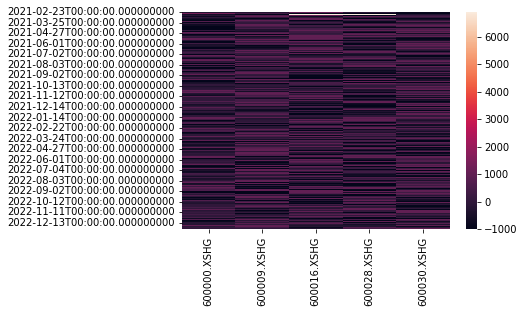

In [17]:
import seaborn as sns
sns.heatmap(actions_memory.iloc[1:]) # the first timestep is the initial hold trading

## stop ray

In [18]:
import ray
ray.shutdown()